In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
load('/import/mdd.rna/GSE101521.rda')

In [3]:
count = expr3

In [4]:
dim(count)

[1] 33714    60

In [96]:
rownames(count) = count[,1]

In [97]:
count = count[,-1]

In [98]:
count = log2(count + 1)

In [99]:
cli$V2 = gsub('-S','',cli$V2 )

In [100]:
library(dplyr)

In [101]:
rownames(cli) = cli[,1]

In [102]:
con.sample = cli %>%  dplyr::filter(V2 =='CON') %>% rownames()

In [103]:
MDD.sample = cli %>%  dplyr::filter(V2 =='MDD') %>% rownames()

In [104]:
control = count[,con.sample]
MDD = count[,MDD.sample]

In [13]:
exp <- cbind(control, MDD)

In [14]:
group=c(rep("control",dim(control)[2]),rep("MDD",dim(MDD)[2])) 

In [15]:
# library("edgeR")  
# library(dplyr)
# library(ggrepel)
# library(ggplot2)
# library(cowplot)

# dimnames=list(rownames(exp),colnames(exp))
# data=matrix(as.numeric(as.matrix(exp)),nrow=nrow(exp),dimnames=dimnames)
# data=avereps(data)
# data=data[rowMeans(data)>1,]
# design <- model.matrix(~group)
# y <- DGEList(counts=data,group=group)
# y <- calcNormFactors(y)
# y <- estimateCommonDisp(y)
# y <- estimateTagwiseDisp(y)
# et <- exactTest(y,pair = c("control","MDD"))
# topTags(et)

# foldChange=0    
# padj=0.05

# ordered_tags <- topTags(et, n=100000)
#     allDiff=ordered_tags$table
#     allDiff=allDiff[is.na(allDiff$FDR)==FALSE,]
#     diff=allDiff
#     diff$group = as.factor(ifelse(diff$PValue < padj & abs(diff$logFC) >= foldChange, 
#                                  ifelse(diff$logFC> foldChange ,'Up','Down'),'NoSignifi'))
#     table(diff$group)

### limma

In [16]:
data  = exp 

In [17]:
library(edgeR)

Warning message:
"package 'edgeR' was built under R version 4.2.3"
Loading required package: limma

Warning message:
"package 'limma' was built under R version 4.2.3"


In [18]:
group_list = factor(group)
design <- model.matrix(~0+group_list)
rownames(design) = colnames(data)
colnames(design) <- levels(group_list)

keep_gene
FALSE  TRUE 
 2208 31506 

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MRPS6,-0.06437148,5.816362,-4.594553,2.275043e-05,0.3737141,2.26043308
LINC00943,-0.32588974,5.262539,-4.140891,1.097314e-04,0.6621735,1.14400540
TUBD1,0.06094105,5.596678,3.947998,2.093795e-04,0.6621735,0.36781966
MRNIP-DT,0.21304026,4.850337,3.965557,1.975412e-04,0.6621735,0.26160144
LOC100129203,-0.07387374,5.394028,-3.738612,4.149462e-04,0.6621735,-0.09855395
LNCRNA-IUR,-0.07387374,5.394028,-3.738612,4.149462e-04,0.6621735,-0.09855395


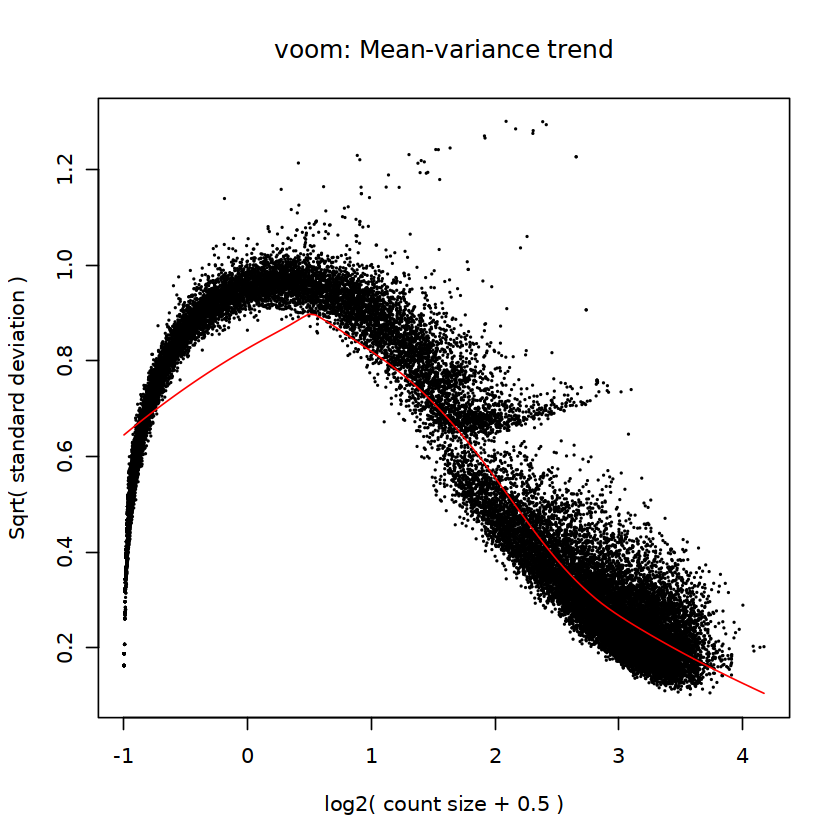

In [19]:
DGElist <- DGEList( counts = data, group = group_list )
keep_gene <- rowSums( cpm(DGElist) > 1 ) >= 1 # 自定义
table(keep_gene)
DGElist <- DGElist[ keep_gene, , keep.lib.sizes = FALSE ]

DGElist <- calcNormFactors( DGElist )
v <- voom(DGElist, design, plot = TRUE, normalize = "quantile")
fit <- lmFit(v, design)
cont.matrix <- makeContrasts(contrasts = c('MDD-control'), levels = design)

fit2 <- contrasts.fit(fit, cont.matrix)
fit2 <- eBayes(fit2)

nrDEG_limma_voom = topTable(fit2, coef = 'MDD-control', n = Inf)
nrDEG_limma_voom = na.omit(nrDEG_limma_voom)
head(nrDEG_limma_voom)


In [20]:
padj = 0.05 # 自定义
foldChange= 0 # 自定义
nrDEG_limma_voom_signif = nrDEG_limma_voom[(nrDEG_limma_voom$P.Value < padj & 
                          (nrDEG_limma_voom$logFC>foldChange | nrDEG_limma_voom$logFC<(-foldChange))),]
nrDEG_limma_voom_signif = nrDEG_limma_voom_signif[order(nrDEG_limma_voom_signif$logFC),]
#save(nrDEG_limma_voom_signif, file = 'nrDEG_limma_voom_signif')


In [21]:
head(nrDEG_limma_voom)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MRPS6,-0.06437148,5.816362,-4.594553,2.275043e-05,0.3737141,2.26043308
LINC00943,-0.32588974,5.262539,-4.140891,1.097314e-04,0.6621735,1.14400540
TUBD1,0.06094105,5.596678,3.947998,2.093795e-04,0.6621735,0.36781966
MRNIP-DT,0.21304026,4.850337,3.965557,1.975412e-04,0.6621735,0.26160144
LOC100129203,-0.07387374,5.394028,-3.738612,4.149462e-04,0.6621735,-0.09855395
LNCRNA-IUR,-0.07387374,5.394028,-3.738612,4.149462e-04,0.6621735,-0.09855395


In [22]:
diff = nrDEG_limma_voom

In [23]:
diff$group = as.factor(ifelse(diff$P.Value < padj & abs(diff$logFC) >= foldChange, 
                                 ifelse(diff$logFC> foldChange ,'Up','Down'),'NoSignifi'))
    table(diff$group)


     Down NoSignifi        Up 
      942     29533      1031 

In [24]:
crg = read.table('./00_rawdata/crg.txt',header =T,sep = '\t')

In [25]:
head(crg,1)

,MGI.Gene.Marker.ID,Symbol,Name,Chr,Qualifier,Annotated.Term,Context,Proteoform,Evidence,Inferred.From,Reference.s.
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,MGI:1919440,2510009E07Rik,RIKEN cDNA 2510009E07 gene,16,NA,circadian behavior,,,ISS,Q1LY84,J:342587


In [26]:
library(homologene)

In [27]:
genelist = crg$Symbol
homo = homologene(genelist, inTax = 10090, outTax = 9606)

In [28]:
head(homo,2)

,10090,9606,10090_ID,9606_ID
,<chr>,<chr>,<int>,<int>
1,2510009E07Rik,C3orf70,72190,285382
2,Aanat,AANAT,11298,15


In [29]:
table(diff$group)


     Down NoSignifi        Up 
      942     29533      1031 

In [30]:
head(diff,2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
MRPS6,-0.06437148,5.816362,-4.594553,2.275043e-05,0.3737141,2.260433,Down
LINC00943,-0.32588974,5.262539,-4.140891,1.097314e-04,0.6621735,1.144005,Down


In [31]:
diff$change = diff$group

In [32]:
library(dplyr)

In [33]:
data <- 
  diff %>% 
  mutate(change = as.factor(ifelse(P.Value < 0.05 & abs(logFC) > 0,
                                   ifelse(logFC > 0 ,'Up','Down'),'NOT'))) %>% 
  tibble::rownames_to_column('gene')

In [34]:
table(data$change)


 Down   NOT    Up 
  942 29533  1031 

In [35]:
head(data,3)

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,group,change
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,MRPS6,-0.06437148,5.816362,-4.594553,2.275043e-05,0.3737141,2.2604331,Down,Down
2,LINC00943,-0.32588974,5.262539,-4.140891,1.097314e-04,0.6621735,1.1440054,Down,Down
3,TUBD1,0.06094105,5.596678,3.947998,2.093795e-04,0.6621735,0.3678197,Up,Up


In [36]:
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(cowplot)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'ggpubr' was built under R version 4.2.3"
Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Warning message:
"package 'cowplot' was built under R version 4.2.3"

Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




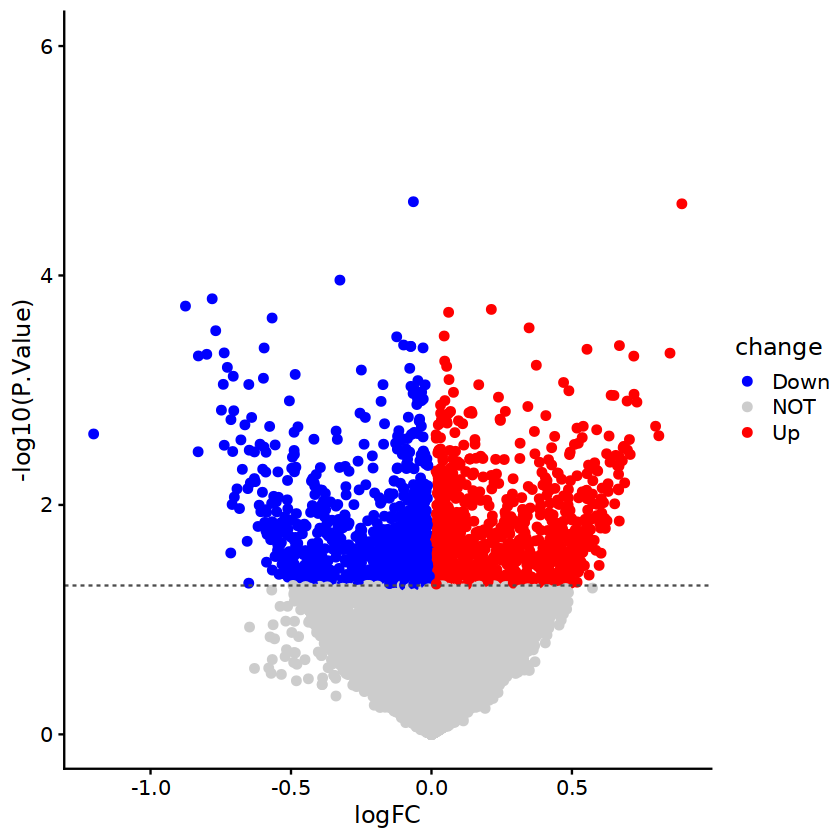

In [37]:
top_5 <- bind_rows(   
      data %>%
        filter(change == 'Up') %>%
        arrange(P.Value, desc(logFC)) %>%
        head(0),
      data %>%
        filter(change == 'Down') %>%
        arrange(P.Value, desc(logFC)) %>%
        head(0)
    )
    ggplot(data=data,aes(x=logFC,y=-log10(P.Value)))+
    geom_point(aes(color=change),size=2)+
    geom_hline(yintercept = -log10(0.05), linetype="dashed",color="grey30")+
    #geom_vline(xintercept = c(-0.3,0.3),linetype="dashed",color="grey30")+
    geom_text_repel(data=top_5,aes(x= logFC,y= -log10(P.Value),label= rownames(top_5)))+
    scale_color_manual(values = c("blue","grey80","red"))+
    theme_half_open() +ylim(0,6)#+xlim(-1.5,1.5)
    ggsave('Volcano.pdf',height = 8,width = 8)

In [38]:
diff1 = data %>%  dplyr::filter(change != 'NOT')

In [39]:
dim(diff1)

[1] 1973    9

In [40]:
tail(diff1,2)

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,group,change
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1972,GLUL,-0.03391529,6.713593,-2.074812,0.04229643,0.7814547,-5.975514,Down,Down
1973,MTURN,0.01713250,6.691455,2.009638,0.04896861,0.7939472,-6.062679,Up,Up


In [41]:
sample_list <- list(DEGs = diff1$gene, CRGs = homo[,2])

In [42]:
library(venn)
        library(VennDiagram)
        color=c( "#3C5488B2","#00A087B2", 
             "#F39B7FB2","#91D1C2B2", 
             "#8491B4B2", "#DC0000B2", 
             "#7E6148B2","yellow", 
             "darkolivegreen1", "lightskyblue", 
             "darkgreen", "deeppink", "khaki2", 
             "firebrick", "brown1", "darkorange1", 
             "cyan1", "royalblue4", "darksalmon", 
             "darkgoldenrod1", "darkseagreen", "darkorchid")

Warning message:
"package 'venn' was built under R version 4.2.3"
Loading required package: grid

Loading required package: futile.logger

Warning message:
"package 'futile.logger' was built under R version 4.2.3"

Attaching package: 'VennDiagram'


The following object is masked from 'package:ggpubr':

    rotate




In [43]:
q <- venn.diagram(sample_list,filename = NULL,
             fill = color[1:(length(sample_list))],
             alpha = 0.50, cat.col = rep('black', 2), 
             col = 'black', cex = 1, fontfamily = 'serif', cat.cex = 1, cat.fontfamily = 'serif', margin = 0.2
                             )
    pdf(paste0('./',"venn.pdf"))
    grid.draw(q)
    dev.off()

png 
  2

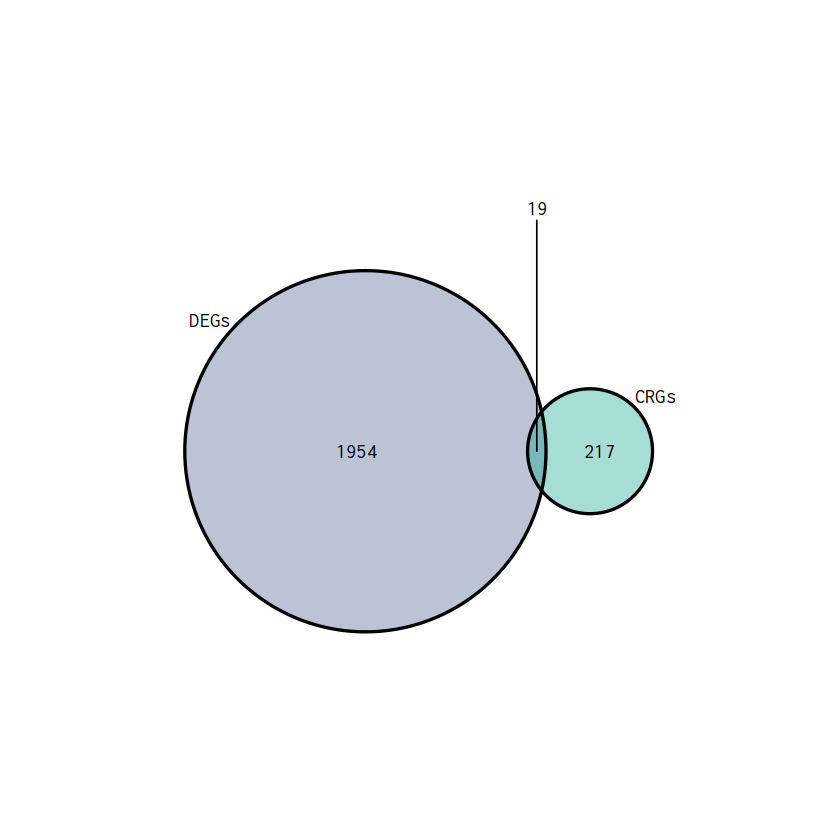

In [44]:
grid.draw(q)

In [45]:
jiaoji = intersect(diff1$gene,homo[,2])

In [46]:
#exp<- read.table("./00_rawdata/exp.txt",sep = '\t',header = T,row.names = 1) 

In [47]:
data1 = exp[c('RPE65' ,'DRD3', 'MC3R','RELB',  'PRF1'),]

In [48]:
dim(data1)

[1]  5 59

In [49]:
head(data1,2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V11,...,V28,V31,V38,V41,V48,V50,V51,V54,V55,V56
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPE65,3.694608,3.612550,3.050758,4.653209,4.078557,4.338465,3.012600,4.294020,3.955365,4.295561,...,1.654528,3.6644160,2.96051,3.54595,3.690635,3.521042,1.2192795,3.195317,2.279349,2.529250
DRD3,0.000000,1.168619,1.146924,1.825147,1.959796,1.767155,1.362414,1.471464,2.210432,0.000000,...,0.000000,0.7907414,0.00000,0.00000,0.000000,1.457676,0.7347872,0.000000,1.192108,1.480145


In [50]:
gene <- t(data1)

In [51]:
#gene <- log(gene+1)

In [52]:
gene_cor <- cor(gene, method = 'pearson')

In [53]:
diag(gene_cor) <- 0

In [54]:
gene_cor <- reshape2::melt(gene_cor)
gene_cor <- subset(gene_cor, value != 0)  #去除0值的相关性
head(gene_cor)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
2,DRD3,RPE65,0.3712060
3,MC3R,RPE65,0.2246960
4,RELB,RPE65,0.3164340
5,PRF1,RPE65,0.1941443
6,RPE65,DRD3,0.3712060
8,MC3R,DRD3,-0.0324455


In [55]:
library(circlize)
pdf('cor.circle2.pdf',height = 6,width = 6)
p=chordDiagram(gene_cor, 
    annotationTrack = c('grid', 'name', 'axis'), #绘制外周圆弧区，显示名称和刻度轴
    grid.col = c(GABRD = 'green3', PLVAP = 'red', CDKN3 = 'orange', CDC25C = 'purple', UBE2T = 'skyblue', SKA1 = 'blue'), #定义基因颜色
    col = colorRamp2(c(-1, 0, 1), c('green', 'white', 'red'), transparency = 0.5), #根据相关性大小展示连线的颜色范围
    annotationTrackHeight = c(0.05, 0.05), #名称离圆弧的距离，以及圆弧的宽度
)
dev.off()

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




png 
  2

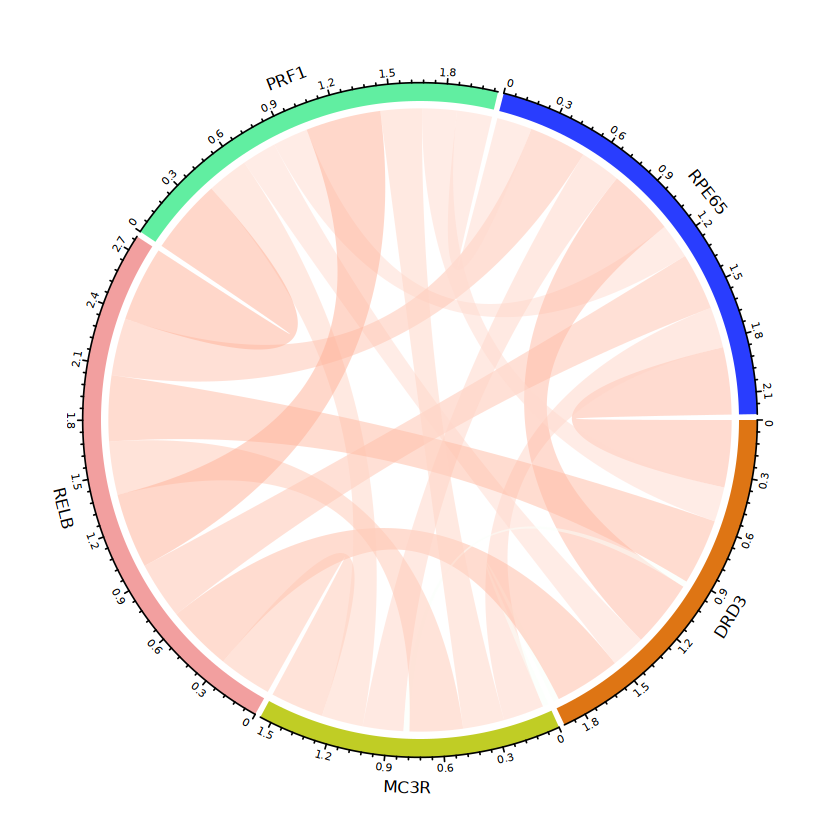

In [56]:
chordDiagram(gene_cor, 
    annotationTrack = c('grid', 'name', 'axis'), #绘制外周圆弧区，显示名称和刻度轴
    #grid.col = c(GABRD = 'green3', PLVAP = 'red', CDKN3 = 'orange', CDC25C = 'purple', UBE2T = 'skyblue', SKA1 = 'blue'), #定义基因颜色
    col = colorRamp2(c(-1, 0, 1), c('green', 'white', 'red'), transparency = 0.5), #根据相关性大小展示连线的颜色范围
    annotationTrackHeight = c(0.05, 0.05), )#名称离圆弧的距离，以及圆弧的宽度

In [57]:
head(data1,2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V11,...,V28,V31,V38,V41,V48,V50,V51,V54,V55,V56
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPE65,3.694608,3.612550,3.050758,4.653209,4.078557,4.338465,3.012600,4.294020,3.955365,4.295561,...,1.654528,3.6644160,2.96051,3.54595,3.690635,3.521042,1.2192795,3.195317,2.279349,2.529250
DRD3,0.000000,1.168619,1.146924,1.825147,1.959796,1.767155,1.362414,1.471464,2.210432,0.000000,...,0.000000,0.7907414,0.00000,0.00000,0.000000,1.457676,0.7347872,0.000000,1.192108,1.480145


In [58]:
library(pheatmap)

Warning message:
"package 'pheatmap' was built under R version 4.2.3"


In [59]:
#da=log2(data1+1)
dat=t(scale(t(data1))) # 'scale'可以对log(fpkm+1)数值进行归一化
#处理数据
dat[dat>2]=2
dat[dat<(-2)]= -2
dim(dat)

[1]  5 59

In [60]:
options(repr.plot.width = 6,repr.plot.height = 4)

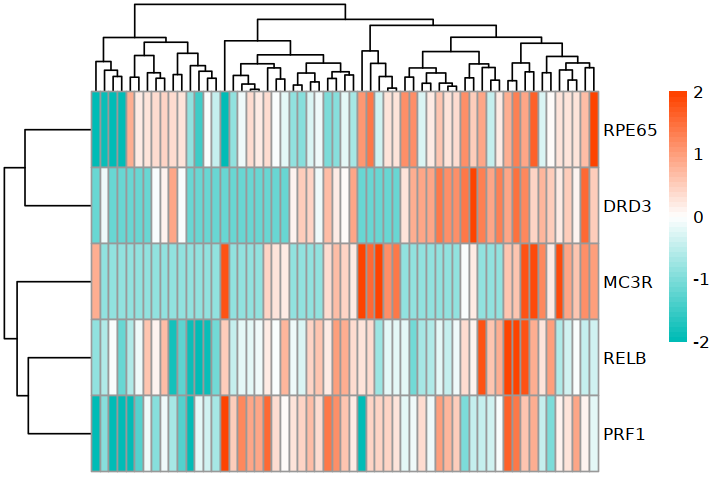

In [61]:
xx = pheatmap(dat,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         show_rownames=TRUE,
         show_colnames = FALSE,
          scale="none",
          #cluster_cols = F,
          fontsize_row = 10,
          fontsize_col = 10,
          #color = colorRampPalette(c("navy", "white", "firebrick3"))(100),
          color = colorRampPalette(c("#00BCB6", "white", "#FE4300"))(50),#换颜色
          angle_col = 45 #修改横轴坐标名倾斜度
)

In [62]:
save_pheatmap_pdf <- function(x, filename, width=8, height=6) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

save_pheatmap_pdf(xx, "heatmap2.pdf")

png 
  2

In [63]:
library(readxl)

Warning message:
"package 'readxl' was built under R version 4.2.3"


In [64]:
group = cli[,c(1,2)]

In [65]:
colnames(group) = c('Symbol','Group')

In [66]:
head(group,2)

,Symbol,Group
,<chr>,<chr>
V35,V35,MDD
V36,V36,MDD


In [67]:
expr = gene %>% as.data.frame() %>% 
tibble::rownames_to_column(.,'sample')

In [68]:
expr1 = merge(group,expr,by.x = 'Symbol',by.y = 'sample')

In [69]:
head(expr1,2)

,Symbol,Group,RPE65,DRD3,MC3R,RELB,PRF1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V1,CON,3.694608,0,1.31814,4.548540,2.801941
2,V10,MDD,2.381054,0,0.00000,3.526436,0.000000


In [70]:
require(cowplot)
require(tidyverse)
require(ggplot2)
require(ggsci)
require(ggpubr)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.1     v purrr   1.0.1
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.4     v forcats 1.0.0
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: ggsci

Warning message:
"package 'ggsci' was built under R version 4.2.3"


In [71]:
colnames(expr1)

[1] "Symbol" "Group"  "RPE65"  "DRD3"   "MC3R"   "RELB"   "PRF1"

In [72]:
mydata<-expr1 %>% 
  ## 基因表达数据gather,gather的范围应调整
  gather(key="gene",value="Expression",RPE65:PRF1) %>% 
  ##
  dplyr::select(Group,gene,Expression) 

In [73]:
head(mydata,2)

compare_means( Expression ~ Group, data = mydata, method = 't.test',
              group.by = "gene")
# Box plot facetted by "gene"
p <- ggboxplot(mydata, x = "Group", y = "Expression",
          color = "Group", palette = "jco",
          add = "jitter",
          facet.by = "gene", short.panel.labs = FALSE)
# Use only p.format as label. Remove method name.
#p + stat_compare_means(label =  "p.signif", label.x = 1.5)
p <- ggboxplot(mydata, x = "gene", y = "Expression",
          color = "Group", palette = "nejm",
          add = "jitter")

diffgene = as.data.frame(compare_means( Expression ~ Group, data = mydata, method = 't.test',
              group.by = "gene"))

diffgene = rownames(diffgene) = diffgene[,1]

write.csv(diffgene,file = 'diffgene2.csv')

options(repr.plot.height = 5,repr.plot.width = 9)

,Group,gene,Expression
,<chr>,<chr>,<dbl>
1,CON,RPE65,3.694608
2,MDD,RPE65,2.381054


gene,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
RPE65,Expression,CON,MDD,0.0001385722,0.00069,0.00014,***,T-test
DRD3,Expression,CON,MDD,0.0027391718,0.01100,0.00274,**,T-test
MC3R,Expression,CON,MDD,0.0044667703,0.01300,0.00447,**,T-test
RELB,Expression,CON,MDD,0.0166906343,0.03300,0.01669,*,T-test
PRF1,Expression,CON,MDD,0.0323607987,0.03300,0.03236,*,T-test


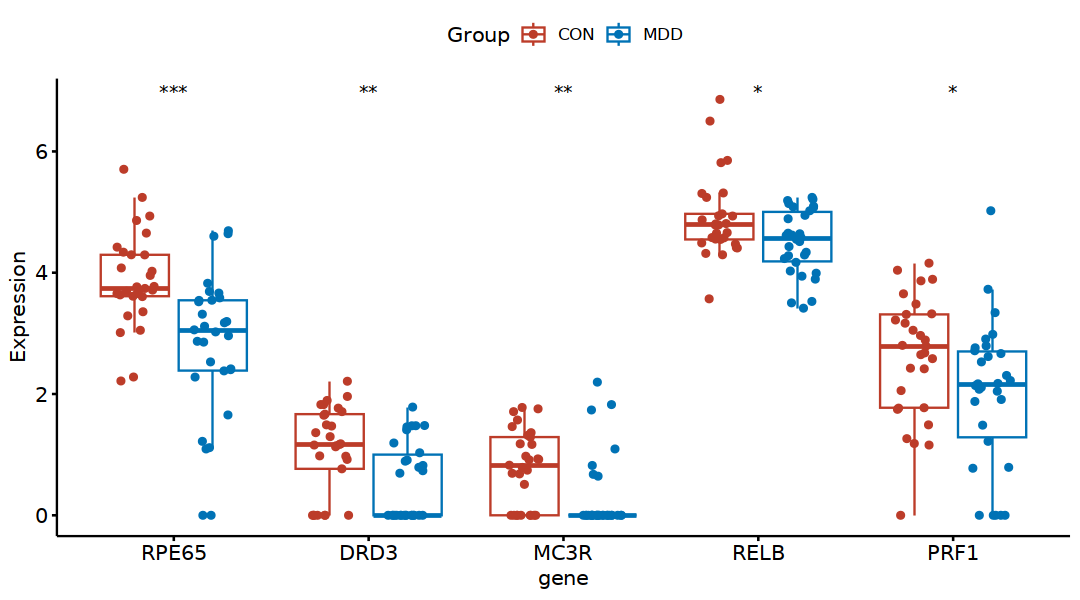

In [74]:
p + stat_compare_means(aes(group = Group), label = "p.signif",method = 't.test')

In [75]:
ggsave('boxplot2.pdf',height = 6,width = 16)

In [76]:
head(cli,2)

,V1,V2,V3,V4
,<chr>,<chr>,<int>,<chr>
V35,V35,MDD,19,Male
V36,V36,MDD,67,Male


In [77]:
head(expr1,2)

,Symbol,Group,RPE65,DRD3,MC3R,RELB,PRF1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V1,CON,3.694608,0,1.31814,4.548540,2.801941
2,V10,MDD,2.381054,0,0.00000,3.526436,0.000000


In [78]:
expr2 = merge(cli,expr1,by.x = 'V1',by.y = 'Symbol')

In [79]:
head(expr2,2)

,V1,V2,V3,V4,Group,RPE65,DRD3,MC3R,RELB,PRF1
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V1,CON,17,Male,CON,3.694608,0,1.31814,4.548540,2.801941
2,V10,MDD,59,Female,MDD,2.381054,0,0.00000,3.526436,0.000000


In [80]:
expr2 = expr2 %>%  dplyr::filter(Group == 'MDD')

## 年龄

In [81]:
table(expr2$V3)


13 17 19 25 30 52 53 57 58 59 60 61 62 64 65 66 67 68 69 70 73 83 
 1  2  2  1  1  1  1  1  1  1  1  3  2  1  2  1  2  1  2  1  1  1 

In [82]:
expr2$V3 = ifelse(expr2$V3  > 60,'old','young')

In [83]:
table(expr2$V3)


  old young 
   17    13 

In [84]:
mydata<-expr2 %>% 
  ## 基因表达数据gather,gather的范围应调整
  gather(key="gene",value="Expression",RPE65:PRF1) %>% 
  ##
  dplyr::select(V3,gene,Expression) 

In [85]:
head(mydata,2)
compare_means( Expression ~ V3, data = mydata, method = 't.test',
              group.by = "gene")
# Box plot facetted by "gene"
p <- ggboxplot(mydata, x = "V3", y = "Expression",
          color = "V3", palette = "jco",
          add = "jitter",
          facet.by = "gene", short.panel.labs = FALSE)
# Use only p.format as label. Remove method name.
#p + stat_compare_means(label =  "p.signif", label.x = 1.5)
p <- ggboxplot(mydata, x = "gene", y = "Expression",
          color = "V3", palette = "nejm",
          add = "jitter")

diffgene = as.data.frame(compare_means( Expression ~ V3, data = mydata, method = 't.test',
              group.by = "gene"))

diffgene = rownames(diffgene) = diffgene[,1]

write.csv(diffgene,file = 'diffgene2.age.csv')

options(repr.plot.height = 5,repr.plot.width = 9)

,V3,gene,Expression
,<chr>,<chr>,<dbl>
1,young,RPE65,2.381054
2,young,RPE65,4.601485


gene,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
RPE65,Expression,young,old,0.8762763,1.00,0.88,ns,T-test
DRD3,Expression,young,old,0.6282365,1.00,0.63,ns,T-test
MC3R,Expression,young,old,0.9031276,1.00,0.90,ns,T-test
RELB,Expression,young,old,0.7019983,1.00,0.70,ns,T-test
PRF1,Expression,young,old,0.1168404,0.58,0.12,ns,T-test


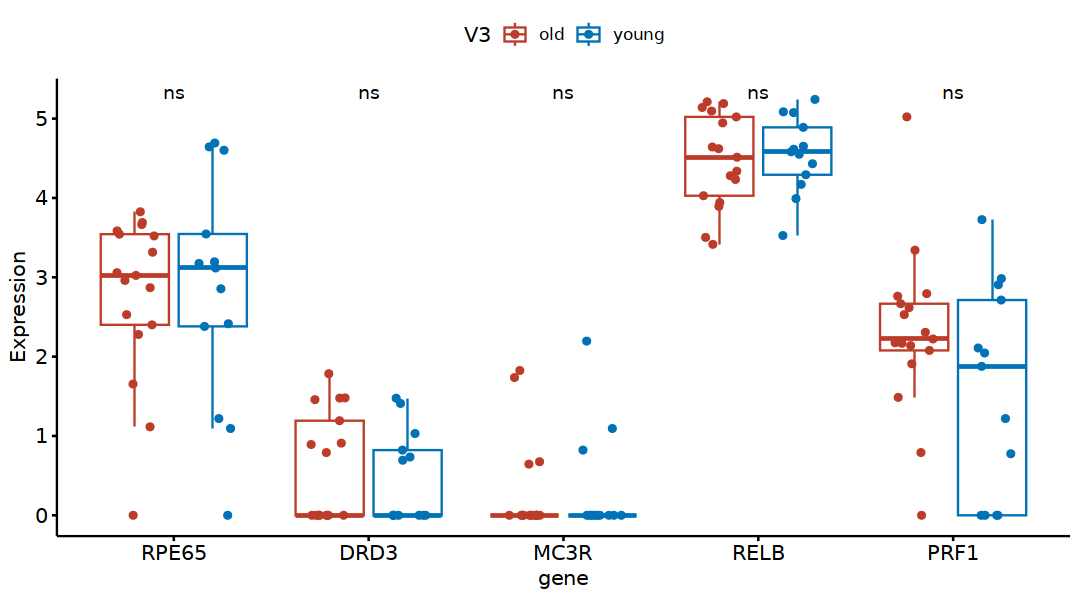

In [86]:
p + stat_compare_means(aes(group = V3), label = "p.signif",method = 't.test')

### 性别

In [87]:
mydata<-expr2 %>% 
  ## 基因表达数据gather,gather的范围应调整
  gather(key="gene",value="Expression",RPE65:PRF1) %>% 
  ##
  dplyr::select(V4,gene,Expression) 

In [88]:
head(mydata,2)
compare_means( Expression ~ V4, data = mydata, method = 't.test',
              group.by = "gene")
# Box plot facetted by "gene"
p <- ggboxplot(mydata, x = "V4", y = "Expression",
          color = "V4", palette = "jco",
          add = "jitter",
          facet.by = "gene", short.panel.labs = FALSE)
# Use only p.format as label. Remove method name.
#p + stat_compare_means(label =  "p.signif", label.x = 1.5)
p <- ggboxplot(mydata, x = "gene", y = "Expression",
          color = "V4", palette = "nejm",
          add = "jitter")

diffgene = as.data.frame(compare_means( Expression ~ V4, data = mydata, method = 't.test',
              group.by = "gene"))

diffgene = rownames(diffgene) = diffgene[,1]

write.csv(diffgene,file = 'diffgene2.sex.csv')

options(repr.plot.height = 5,repr.plot.width = 9)

,V4,gene,Expression
,<chr>,<chr>,<dbl>
1,Female,RPE65,2.381054
2,Male,RPE65,4.601485


gene,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
RPE65,Expression,Female,Male,0.83566282,1.000,0.836,ns,T-test
DRD3,Expression,Female,Male,0.67133805,1.000,0.671,ns,T-test
MC3R,Expression,Female,Male,0.01141281,0.057,0.011,*,T-test
RELB,Expression,Female,Male,0.90189036,1.000,0.902,ns,T-test
PRF1,Expression,Female,Male,0.40493605,1.000,0.405,ns,T-test


In [91]:
table(expr2$V4)


Female   Male 
    11     19 

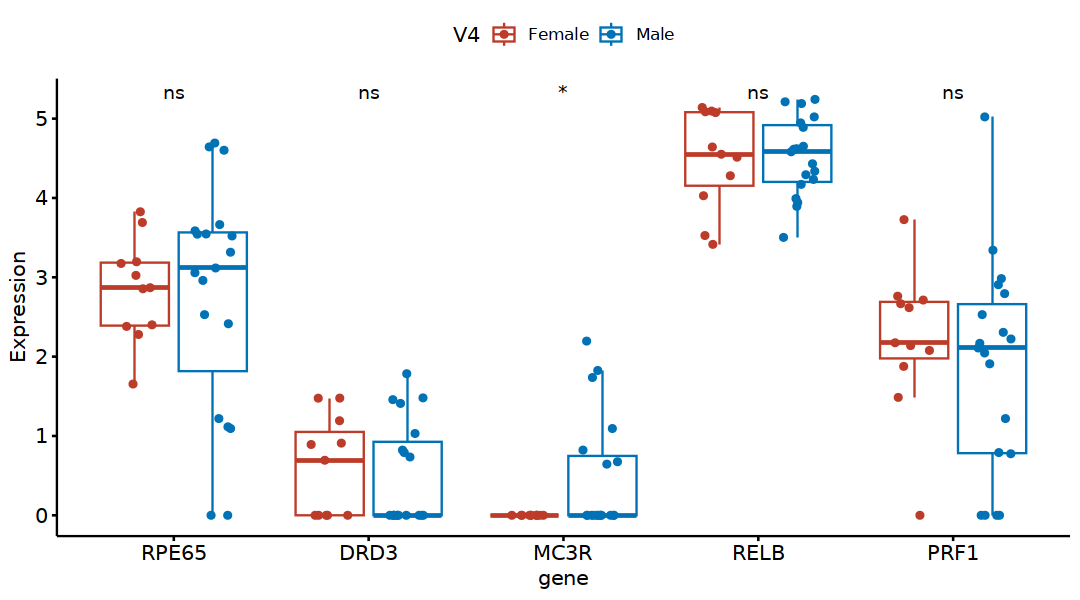

In [89]:
p + stat_compare_means(aes(group = V4), label = "p.signif",method = 't.test')

In [145]:
head(expr2,2)

,V1,V2,V3,V4,Group,RPE65,DRD3,MC3R,RELB,PRF1
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V10,MDD,old,Female,MDD,2.381054,0,0.000000,3.526436,0
2,V15,MDD,young,Male,MDD,4.601485,0,2.195659,4.889859,0
